In [6]:
import pandas as pd
from tensorflow import keras
from os import path
import pickle


In [4]:
from proteinbert.finetuning import encode_train_and_valid_sets, encode_dataset
from proteinbert import OutputType, OutputSpec, evaluate_by_len, load_pretrained_model

In [5]:
from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, \
finetune, evaluate_by_len

from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

In [6]:
import wandb
from wandb.keras import WandbCallback

In [7]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [8]:
DATA_DIR = "../../data/"

In [9]:
OUTPUT_TYPE = OutputType(False, 'binary')
UNIQUE_LABELS = [0, 1]
OUTPUT_SPEC = OutputSpec(OUTPUT_TYPE, UNIQUE_LABELS)

In [10]:
pretrained_model_generator, input_encoder = load_pretrained_model("../../data/protein_bert/", "epoch_92400_sample_23500000.pkl")

In [20]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [12]:
train_set = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_train.csv"), index_col=0)
test_set = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_test.csv"), index_col=0)
train_set["seq"] = train_set["heavy"] + train_set["light"]
test_set["seq"] = test_set["heavy"] + test_set["light"]

In [11]:
len(train_set)

1291

In [12]:
len(test_set)

260

In [13]:
learning_rate = 1e-4
patience = (6, 4)

In [2]:
sizes = [0.5, 0.6, 0.7, 0.8, 0.9]

In [16]:
def train_and_save_model(train_data, valid_data, test_data, size):
    wandb.init(project=f"Dataset size exp", entity="kvetab")
    model_generator = FinetuningModelGenerator(pretrained_model_generator, OUTPUT_SPEC, pretraining_model_manipulation_function = \
            get_model_with_hidden_layers_as_outputs, dropout_rate = 0.5)

    training_callbacks = [
        keras.callbacks.ReduceLROnPlateau(patience = patience[1], factor = 0.25, min_lr = 1e-07, verbose = 1),
        keras.callbacks.EarlyStopping(patience = patience[0], restore_best_weights = True),
        WandbCallback()
    ]

    epoch_num = 100
    batch_size = 128
    #learning_rate = 1e-5
    wandb.config = {
          "learning_rate": learning_rate,
          "epochs": epoch_num * 2,
          "batch_size": batch_size
        }
    finetune(model_generator, input_encoder, OUTPUT_SPEC, train_data["seq"], train_data["Y"], valid_data['seq'], valid_data["Y"], \
            seq_len = 512, batch_size = batch_size, max_epochs_per_stage = epoch_num, lr = learning_rate, begin_with_frozen_pretrained_layers = True, \
            lr_with_frozen_pretrained_layers = 1e-02, n_final_epochs = 1, final_seq_len = 1024, final_lr = learning_rate / 10, callbacks = training_callbacks)
    mod = model_generator.create_model(seq_len = 512)
    mod_name = f"2022_04_22_size{size}"
    mod.save(path.join(DATA_DIR, f"protein_bert/by_data_size/{mod_name}"))

    results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, test_data['seq'], test_data['Y'], \
            start_seq_len = 512, start_batch_size = 32)
    fn_fp = confusion_matrix.loc["0"][1] + confusion_matrix.loc["1"][0]
    f1 = confusion_matrix.loc["1"][1] / (confusion_matrix.loc["1"][1] + 0.5 * fn_fp)
    return confusion_matrix, f1

In [15]:
cms = {}
f1s = {}

In [21]:
for size in sizes:
    train, valid = train_test_split(train_set, test_size=1-size, random_state=42, stratify=train_set["Y"])
    #test = pd.concat([test, test_set])
    test = test_set
    #valid, test = train_test_split(test, test_size=0.5, random_state=333, stratify=test["Y"])
    print(len(train), len(valid), len(test))
    cm, f1_score = train_and_save_model(train, valid, test, size)
    cms[size] = cm
    f1s[size] = f1_score

645 646 260


NameError: name 'train_and_save_model' is not defined

In [1]:
size = 1
train = train_set
valid, test = train_test_split(test_set, test_size=0.5, random_state=333, stratify=test_set["Y"])
print(len(train_set), len(valid), len(test))
cm, f1_score = train_and_save_model(train, valid, test, size)
cms[size] = cm
f1s[size] = f1_score

NameError: name 'train_set' is not defined

In [19]:
f1s

{0.5: 0.37894736842105264,
 0.6: 0.4864864864864865,
 0.7: 0.43010752688172044,
 0.8: 0.4807692307692308,
 0.9: 0.5094339622641509,
 1: 0.5531914893617021}

### Get other metrics

In [14]:
def evaluate_model(model_name, dir_name, x_test, y_test):
    model_path = path.join(DATA_DIR, f"protein_bert/{dir_name}/{model_name}")
    model = keras.models.load_model(model_path)
    
    y_pred = model.predict(x_test, batch_size=32)
    y_pred_classes = (y_pred >= 0.5)
    #print(f"Model {model_name}")
    #print(f"Test F1: {f1}")
    metric_dict = {
        "f1": float(metrics.f1_score(y_test, y_pred_classes)),
        "acc": float(metrics.accuracy_score(y_test, y_pred_classes)),
        "mcc": float(metrics.matthews_corrcoef(y_test, y_pred_classes)),
        "auc": float(metrics.roc_auc_score(y_test, y_pred_classes)),
        "precision": float(metrics.precision_score(y_test, y_pred_classes)),
        "recall": float(metrics.recall_score(y_test, y_pred_classes))
    }
    print("======================")
    print(model_name)
    print(metric_dict)
    print("\n")

In [18]:
seq_len = 512

In [22]:
for size in sizes:
    train, valid = train_test_split(train_set, test_size=1-size, random_state=42, stratify=train_set["Y"])
    test = test_set
    encoded_test_set = encode_dataset(test["seq"], test["Y"], input_encoder, OUTPUT_SPEC, seq_len = seq_len, needs_filtering = True, \
                dataset_name = 'Test set')
    test_X, test_Y, test_sample_weigths = encoded_test_set
    model_name = f"2022_04_22_size{size}"
    evaluate_model(model_name, "by_data_size", test_X, test_Y)
train = train_set
valid, test = train_test_split(test_set, test_size=0.5, random_state=333, stratify=test_set["Y"])
encoded_test_set = encode_dataset(test["seq"], test["Y"], input_encoder, OUTPUT_SPEC, seq_len = seq_len, needs_filtering = True, \
            dataset_name = 'Test set')
test_X, test_Y, test_sample_weigths = encoded_test_set
model_name = f"2022_04_22_size1"
evaluate_model(model_name, "by_data_size", test_X, test_Y)


[2022_05_03-13:08:02] Test set: Filtered out 0 of 260 (0.0%) records of lengths exceeding 510.
2022_04_22_size0.5
{'f1': 0.37894736842105264, 'acc': 0.7730769230769231, 'mcc': 0.2467451337568806, 'auc': 0.61084142394822, 'precision': 0.43902439024390244, 'recall': 0.3333333333333333}


[2022_05_03-13:08:10] Test set: Filtered out 0 of 260 (0.0%) records of lengths exceeding 510.
2022_04_22_size0.6
{'f1': 0.4864864864864865, 'acc': 0.7807692307692308, 'mcc': 0.3474566939734222, 'auc': 0.6771844660194175, 'precision': 0.47368421052631576, 'recall': 0.5}


[2022_05_03-13:08:19] Test set: Filtered out 0 of 260 (0.0%) records of lengths exceeding 510.
2022_04_22_size0.7
{'f1': 0.43010752688172044, 'acc': 0.7961538461538461, 'mcc': 0.3159812981021656, 'auc': 0.6390686803308163, 'precision': 0.5128205128205128, 'recall': 0.37037037037037035}


[2022_05_03-13:08:27] Test set: Filtered out 0 of 260 (0.0%) records of lengths exceeding 510.
2022_04_22_size0.8
{'f1': 0.4807692307692307, 'acc': 0.7

# CV on all data

In [26]:
chen_data = pd.read_csv(path.join(DATA_DIR, "chen/deduplicated/chen_data_w_clusters.csv"), index_col=0)
chen_data.head()

,Antibody_ID,heavy,light,Y,cluster
0,12e8,EVQLQQSGAEVVRSGASVKLSCTASGFNIKDYYIHWVKQRPEKGLE...,DIVMTQSQKFMSTSVGDRVSITCKASQNVGTAVAWYQQKPGQSPKL...,0,677
1,15c8,EVQLQQSGAELVKPGASVKLSCTASGFNIKDTYMHWVKQKPEQGLE...,DIVLTQSPAIMSASLGERVTMTCTASSSVSSSNLHWYQQKPGSSPK...,0,685
2,1a0q,EVQLQESDAELVKPGASVKISCKASGYTFTDHVIHWVKQKPEQGLE...,DIELTQSPSSLSASLGGKVTITCKASQDIKKYIGWYQHKPGKQPRL...,1,102
3,1a14,QVQLQQSGAELVKPGASVRMSCKASGYTFTNYNMYWVKQSPGQGLE...,DIELTQTTSSLSASLGDRVTISCRASQDISNYLNWYQQNPDGTVKL...,0,442
4,1a2y,QVQLQESGPGLVAPSQSLSITCTVSGFSLTGYGVNWVRQPPGKGLE...,DIVLTQSPASLSASVGETVTITCRASGNIHNYLAWYQQKQGKSPQL...,0,59


In [43]:
chen_data["cluster"].value_counts()

18     59
24     35
28     28
8      25
7      21
       ..
588     1
562     1
786     1
722     1
329     1
Name: cluster, Length: 932, dtype: int64

In [56]:
def split_into_k_sets(k, data):
    total = len(data)
    size = total // k + 1
    clusters_by_size = data["cluster"].value_counts().index
    cluster_sizes = data["cluster"].value_counts()
    groups = { i: [] for i in range(k) }
    group_nums = { i: [] for i in range(k) }
    group = 0
    for clust in clusters_by_size:
        start_group = group
        if len(groups[group]) + cluster_sizes[clust] > size:
            group += 1
            group = group % k
        while len(groups[group]) + cluster_sizes[clust] > size and group != start_group:
            group += 1
            group = group % k
        if len(groups[group]) < size:
            groups[group] += list(data[data["cluster"] == clust].index)
            group_nums[group].append(clust)
        else:
            print("error")
    return groups, group_nums

In [57]:
indices, clusters = split_into_k_sets(10, chen_data)
for key, gr in indices.items():
    print(len(gr))

152
154
155
154
156
156
156
156
156
156


In [46]:
chen_data["seq"] = chen_data["heavy"] + chen_data["light"]

In [20]:
def train_and_save_named_model(train_data, valid_data, test_data, name, project_name):
    wandb.init(project=project_name, entity="kvetab")
    model_generator = FinetuningModelGenerator(pretrained_model_generator, OUTPUT_SPEC, pretraining_model_manipulation_function = \
            get_model_with_hidden_layers_as_outputs, dropout_rate = 0.5)

    training_callbacks = [
        keras.callbacks.ReduceLROnPlateau(patience = patience[1], factor = 0.25, min_lr = 1e-07, verbose = 1),
        keras.callbacks.EarlyStopping(patience = patience[0], restore_best_weights = True),
        WandbCallback()
    ]

    epoch_num = 100
    batch_size = 128
    #learning_rate = 1e-5
    wandb.config = {
          "learning_rate": learning_rate,
          "epochs": epoch_num * 2,
          "batch_size": batch_size
        }
    finetune(model_generator, input_encoder, OUTPUT_SPEC, train_data["seq"], train_data["Y"], valid_data['seq'], valid_data["Y"], \
            seq_len = 512, batch_size = batch_size, max_epochs_per_stage = epoch_num, lr = learning_rate, begin_with_frozen_pretrained_layers = True, \
            lr_with_frozen_pretrained_layers = 1e-02, n_final_epochs = 1, final_seq_len = 1024, final_lr = learning_rate / 10, callbacks = training_callbacks)
    mod = model_generator.create_model(seq_len = 512)
    mod.save(path.join(DATA_DIR, f"protein_bert/{name}"))

    results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, test_data['seq'], test_data['Y'], \
            start_seq_len = 512, start_batch_size = 32)
    fn_fp = confusion_matrix.loc["0"][1] + confusion_matrix.loc["1"][0]
    f1 = confusion_matrix.loc["1"][1] / (confusion_matrix.loc["1"][1] + 0.5 * fn_fp)
    return confusion_matrix, f1

In [71]:
cms = {}
f1s = {}

In [75]:
for i in range(10):
    test = chen_data.loc[indices[i]]
    remaining = [idx for idx in list(chen_data.index) if idx not in indices[i]]
    train = chen_data.loc[remaining]
    train, valid = train_test_split(train, test_size=0.1, random_state=333)
    cm, f1 = train_and_save_named_model(train, valid, test, f"10-fold-cv/2022_04_24_split_{i}", "10_fold_cv")
    cms[i] = cm
    f1s[i] = f1

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█▁▂▂▃▃▄▅▅▆▁
loss,▃▇█▆▂▃▄▁▁▃▃▂▂▁▁▁▁▁▁▁▁▁▁
lr,███████████▃▃▁▁▁▁▁▁▁▁▁▁
val_loss,▇█▆▂▂▃▁▂▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁
best_epoch,2
best_val_loss,0.5482
epoch,0
loss,0.47977
lr,1e-05
val_loss,0.55076


wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[2022_04_25-08:53:30] Training set: Filtered out 0 of 1259 (0.0%) records of lengths exceeding 510.
[2022_04_25-08:53:30] Validation set: Filtered out 0 of 140 (0.0%) records of lengths exceeding 510.
[2022_04_25-08:53:30] Training with frozen pretrained layers...


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 10s 310ms/step - loss: 0.8610 - val_loss: 0.6941


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: ERROR Can't save model, h5py returned error: Layer GlobalAttention has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/100
10/10 [==============================] - 1s 110ms/step - loss: 0.5770 - val_loss: 0.5120
Epoch 3/100
10/10 [==============================] - 1s 111ms/step - loss: 0.4843 - val_loss: 0.5192
Epoch 4/100
10/10 [==============================] - 1s 109ms/step - loss: 0.4796 - val_loss: 0.5333
Epoch 5/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4511 - val_loss: 0.4876
Epoch 6/100
10/10 [==============================] - 1s 111ms/step - loss: 0.4228 - val_loss: 0.4560
Epoch 7/100
10/10 [==============================] - 1s 109ms/step - loss: 0.4083 - val_loss: 0.4341
Epoch 8/100
10/10 [==============================] - 1s 108ms/step - loss: 0.3963 - val_loss: 0.4334
Epoch 9/100
10/10 [==============================] - 1s 108ms/step - loss: 0.3870 - val_loss: 0.4646
Epoch 10/100
10/10 [==============================] - 1s 113ms/step - loss: 0.3892 - val_loss: 0.4552
Epoch 11/100
10/10 [==============================] - 1s 108ms/step - loss: 0.3833 - val_l

10/10 [==============================] - 10s 469ms/step - loss: 0.3714 - val_loss: 0.4478
Epoch 2/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3496 - val_loss: 0.4266
Epoch 3/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3423 - val_loss: 0.4137
Epoch 4/100
10/10 [==============================] - 3s 265ms/step - loss: 0.3290 - val_loss: 0.4124
Epoch 5/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3305 - val_loss: 0.4131
Epoch 6/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3111 - val_loss: 0.4119
Epoch 7/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3026 - val_loss: 0.4150
Epoch 8/100
10/10 [==============================] - 3s 267ms/step - loss: 0.2976 - val_loss: 0.4260
Epoch 9/100
10/10 [==============================] - 3s 267ms/step - loss: 0.2897 - val_loss: 0.4377
Epoch 10/100
10/10 [==============================] - 3s 267ms/step - loss: 0.2865 - val_loss: 0.4220


20/20 [==============================] - 13s 349ms/step - loss: 0.3239 - val_loss: 0.4070


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_0/assets


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_0/assets
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██▁▁▂▂▂▂▃▃▃▄▄▄▁
loss,█▅▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂
lr,███████████████████████▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▃▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▂▁▁▂▁
best_epoch,0
best_val_loss,0.40695
epoch,0
loss,0.32394
lr,1e-05
val_loss,0.40695


wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[2022_04_25-08:56:09] Training set: Filtered out 0 of 1257 (0.0%) records of lengths exceeding 510.
[2022_04_25-08:56:09] Validation set: Filtered out 0 of 140 (0.0%) records of lengths exceeding 510.
[2022_04_25-08:56:09] Training with frozen pretrained layers...


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 10s 307ms/step - loss: 0.8050 - val_loss: 0.8118


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: ERROR Can't save model, h5py returned error: Layer GlobalAttention has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/100
10/10 [==============================] - 1s 108ms/step - loss: 0.5750 - val_loss: 0.5913
Epoch 3/100
10/10 [==============================] - 1s 109ms/step - loss: 0.4917 - val_loss: 0.5065
Epoch 4/100
10/10 [==============================] - 1s 110ms/step - loss: 0.4633 - val_loss: 0.4744
Epoch 5/100
10/10 [==============================] - 1s 109ms/step - loss: 0.4332 - val_loss: 0.4574
Epoch 6/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4395 - val_loss: 0.4602
Epoch 7/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4275 - val_loss: 0.4517
Epoch 8/100
10/10 [==============================] - 1s 111ms/step - loss: 0.4151 - val_loss: 0.4393
Epoch 9/100
10/10 [==============================] - 1s 111ms/step - loss: 0.4046 - val_loss: 0.4240
Epoch 10/100
10/10 [==============================] - 1s 113ms/step - loss: 0.4015 - val_loss: 0.4253
Epoch 11/100
10/10 [==============================] - 1s 110ms/step - loss: 0.3901 - val_l

10/10 [==============================] - 10s 452ms/step - loss: 0.3701 - val_loss: 0.3781
Epoch 2/100
10/10 [==============================] - 3s 271ms/step - loss: 0.3523 - val_loss: 0.3793
Epoch 3/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3573 - val_loss: 0.3706
Epoch 4/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3525 - val_loss: 0.3650
Epoch 5/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3419 - val_loss: 0.3608
Epoch 6/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3438 - val_loss: 0.3591
Epoch 7/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3342 - val_loss: 0.3749
Epoch 8/100
10/10 [==============================] - 3s 271ms/step - loss: 0.3362 - val_loss: 0.3531
Epoch 9/100
10/10 [==============================] - 3s 269ms/step - loss: 0.3207 - val_loss: 0.3515
Epoch 10/100
10/10 [==============================] - 3s 269ms/step - loss: 0.3261 - val_loss: 0.3509


20/20 [==============================] - 13s 353ms/step - loss: 0.3109 - val_loss: 0.3575


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_1/assets


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_1/assets
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███▁▁▂▂▂▂▃▃▃▁
loss,█▅▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁
lr,████████████▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▃▂▂▂▂▂▂▃▂▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,9
best_val_loss,0.35093
epoch,0
loss,0.31087
lr,1e-05
val_loss,0.35749


wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[2022_04_25-08:59:11] Training set: Filtered out 0 of 1256 (0.0%) records of lengths exceeding 510.
[2022_04_25-08:59:11] Validation set: Filtered out 0 of 140 (0.0%) records of lengths exceeding 510.
[2022_04_25-08:59:11] Training with frozen pretrained layers...


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 11s 335ms/step - loss: 0.7739 - val_loss: 0.4855


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: ERROR Can't save model, h5py returned error: Layer GlobalAttention has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/100
10/10 [==============================] - 1s 109ms/step - loss: 0.5156 - val_loss: 0.4227
Epoch 3/100
10/10 [==============================] - 1s 112ms/step - loss: 0.4792 - val_loss: 0.4273
Epoch 4/100
10/10 [==============================] - 1s 110ms/step - loss: 0.4431 - val_loss: 0.4503
Epoch 5/100
10/10 [==============================] - 1s 110ms/step - loss: 0.4515 - val_loss: 0.3991
Epoch 6/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4399 - val_loss: 0.4018
Epoch 7/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4258 - val_loss: 0.3785
Epoch 8/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4088 - val_loss: 0.3853
Epoch 9/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4079 - val_loss: 0.3714
Epoch 10/100
10/10 [==============================] - 1s 115ms/step - loss: 0.3959 - val_loss: 0.3658
Epoch 11/100
10/10 [==============================] - 1s 113ms/step - loss: 0.4010 - val_l

10/10 [==============================] - 10s 452ms/step - loss: 0.3772 - val_loss: 0.3399
Epoch 2/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3864 - val_loss: 0.3710
Epoch 3/100
10/10 [==============================] - 3s 265ms/step - loss: 0.3561 - val_loss: 0.3381
Epoch 4/100
10/10 [==============================] - 3s 265ms/step - loss: 0.3599 - val_loss: 0.3372
Epoch 5/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3453 - val_loss: 0.3385
Epoch 6/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3210 - val_loss: 0.3327
Epoch 7/100
10/10 [==============================] - 3s 269ms/step - loss: 0.3300 - val_loss: 0.3319
Epoch 8/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3157 - val_loss: 0.3483
Epoch 9/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3108 - val_loss: 0.3486
Epoch 10/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3011 - val_loss: 0.3408


20/20 [==============================] - 13s 352ms/step - loss: 0.3096 - val_loss: 0.3388


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_2/assets


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_2/assets
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███▁▁▂▂▂▂▃▁
loss,█▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂
lr,███████▃▃▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▄▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁
best_epoch,11
best_val_loss,0.3279
epoch,0
loss,0.3096
lr,1e-05
val_loss,0.33878


wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[2022_04_25-09:04:16] Training set: Filtered out 0 of 1257 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:04:16] Validation set: Filtered out 0 of 140 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:04:16] Training with frozen pretrained layers...


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 10s 305ms/step - loss: 0.7361 - val_loss: 0.6745


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: ERROR Can't save model, h5py returned error: Layer GlobalAttention has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/100
10/10 [==============================] - 1s 116ms/step - loss: 0.5401 - val_loss: 0.5419
Epoch 3/100
10/10 [==============================] - 1s 113ms/step - loss: 0.5139 - val_loss: 0.4968
Epoch 4/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4533 - val_loss: 0.4624
Epoch 5/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4309 - val_loss: 0.4514
Epoch 6/100
10/10 [==============================] - 1s 112ms/step - loss: 0.4210 - val_loss: 0.4470
Epoch 7/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4214 - val_loss: 0.4446
Epoch 8/100
10/10 [==============================] - 1s 110ms/step - loss: 0.4105 - val_loss: 0.4490
Epoch 9/100
10/10 [==============================] - 1s 112ms/step - loss: 0.3999 - val_loss: 0.4275
Epoch 10/100
10/10 [==============================] - 1s 111ms/step - loss: 0.3960 - val_loss: 0.4170
Epoch 11/100
10/10 [==============================] - 1s 118ms/step - loss: 0.3910 - val_l

10/10 [==============================] - 10s 455ms/step - loss: 0.3671 - val_loss: 0.3825
Epoch 2/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3464 - val_loss: 0.3771
Epoch 3/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3357 - val_loss: 0.3734
Epoch 4/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3267 - val_loss: 0.3699
Epoch 5/100
10/10 [==============================] - 3s 269ms/step - loss: 0.3249 - val_loss: 0.3719
Epoch 6/100
10/10 [==============================] - 3s 272ms/step - loss: 0.3258 - val_loss: 0.3664
Epoch 7/100
10/10 [==============================] - 3s 269ms/step - loss: 0.3272 - val_loss: 0.3636
Epoch 8/100
10/10 [==============================] - 3s 270ms/step - loss: 0.3020 - val_loss: 0.3670
Epoch 9/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3066 - val_loss: 0.3799
Epoch 10/100
10/10 [==============================] - 3s 266ms/step - loss: 0.2992 - val_loss: 0.4688


20/20 [==============================] - 13s 349ms/step - loss: 0.3259 - val_loss: 0.3732


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_3/assets


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_3/assets
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███▁▁▂▂▂▂▃▃▃▁
loss,█▅▅▃▃▃▃▃▃▃▃▂▂▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▂
lr,██████████████████▃▃▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▃▂▂▂▂▂▂▂▂▃▂▃▃▂▁▂▁▂▁▁▂▂▂▁▂▁▁▁▁▁▁▃▂▁▁
best_epoch,6
best_val_loss,0.36359
epoch,0
loss,0.32595
lr,1e-05
val_loss,0.37324


wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[2022_04_25-09:07:03] Training set: Filtered out 0 of 1255 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:07:03] Validation set: Filtered out 0 of 140 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:07:03] Training with frozen pretrained layers...


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 10s 315ms/step - loss: 0.7822 - val_loss: 0.5628


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: ERROR Can't save model, h5py returned error: Layer GlobalAttention has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/100
10/10 [==============================] - 1s 114ms/step - loss: 0.5269 - val_loss: 0.4314
Epoch 3/100
10/10 [==============================] - 1s 107ms/step - loss: 0.4867 - val_loss: 0.4171
Epoch 4/100
10/10 [==============================] - 1s 107ms/step - loss: 0.4573 - val_loss: 0.4122
Epoch 5/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4662 - val_loss: 0.3966
Epoch 6/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4584 - val_loss: 0.3954
Epoch 7/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4232 - val_loss: 0.3680
Epoch 8/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4297 - val_loss: 0.3895
Epoch 9/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4057 - val_loss: 0.3583
Epoch 10/100
10/10 [==============================] - 1s 113ms/step - loss: 0.4138 - val_loss: 0.3791
Epoch 11/100
10/10 [==============================] - 1s 114ms/step - loss: 0.3991 - val_l

10/10 [==============================] - 10s 461ms/step - loss: 0.3759 - val_loss: 0.3166
Epoch 2/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3650 - val_loss: 0.3214
Epoch 3/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3287 - val_loss: 0.3244
Epoch 4/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3359 - val_loss: 0.3169
Epoch 5/100
10/10 [==============================] - 3s 270ms/step - loss: 0.3403 - val_loss: 0.3210

Epoch 00005: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 6/100
10/10 [==============================] - 3s 265ms/step - loss: 0.3173 - val_loss: 0.3161
Epoch 7/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3247 - val_loss: 0.3149
Epoch 8/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3195 - val_loss: 0.3151
Epoch 9/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3009 - val_loss: 0.3145
Epoch 10/100
10/10 [=

20/20 [==============================] - 13s 351ms/step - loss: 0.3286 - val_loss: 0.3127


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_4/assets


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_4/assets
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


epoch,▁▁▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇██▁▁▂▂▂▂▃▃▃▄▄▄▄▁
loss,█▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▂
lr,██████████████████▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▃▃▂▃▂▄▂▂▂▂▂▂▁▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,15
best_val_loss,0.31023
epoch,0
loss,0.32862
lr,1e-05
val_loss,0.31268


wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[2022_04_25-09:11:07] Training set: Filtered out 0 of 1255 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:11:07] Validation set: Filtered out 0 of 140 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:11:07] Training with frozen pretrained layers...


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 10s 312ms/step - loss: 0.7287 - val_loss: 0.6076


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: ERROR Can't save model, h5py returned error: Layer GlobalAttention has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/100
10/10 [==============================] - 1s 111ms/step - loss: 0.5179 - val_loss: 0.4699
Epoch 3/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4529 - val_loss: 0.4603
Epoch 4/100
10/10 [==============================] - 1s 109ms/step - loss: 0.4431 - val_loss: 0.4489
Epoch 5/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4268 - val_loss: 0.4501
Epoch 6/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4283 - val_loss: 0.4665
Epoch 7/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4226 - val_loss: 0.4513
Epoch 8/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4135 - val_loss: 0.4288
Epoch 9/100
10/10 [==============================] - 1s 113ms/step - loss: 0.4003 - val_loss: 0.4266
Epoch 10/100
10/10 [==============================] - 1s 113ms/step - loss: 0.3889 - val_loss: 0.4172
Epoch 11/100
10/10 [==============================] - 1s 114ms/step - loss: 0.3992 - val_l

10/10 [==============================] - 10s 449ms/step - loss: 0.3426 - val_loss: 0.3866
Epoch 2/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3522 - val_loss: 0.3932
Epoch 3/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3347 - val_loss: 0.3794
Epoch 4/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3166 - val_loss: 0.3813
Epoch 5/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3293 - val_loss: 0.3750
Epoch 6/100
10/10 [==============================] - 3s 265ms/step - loss: 0.3391 - val_loss: 0.3698
Epoch 7/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3293 - val_loss: 0.3694
Epoch 8/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3332 - val_loss: 0.4352
Epoch 9/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3287 - val_loss: 0.3951
Epoch 10/100
10/10 [==============================] - 3s 269ms/step - loss: 0.3057 - val_loss: 0.3666


20/20 [==============================] - 13s 350ms/step - loss: 0.2875 - val_loss: 0.3577


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_5/assets


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_5/assets
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▅
loss,█▅▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
lr,███████████████████████▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▄▃▃▂▂▃▂▂▄▂▃▃▂▂▂▂▁▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
best_epoch,0
best_val_loss,0.35775
epoch,0
loss,0.28746
lr,1e-05
val_loss,0.35775


wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[2022_04_25-09:14:19] Training set: Filtered out 0 of 1255 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:14:19] Validation set: Filtered out 0 of 140 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:14:19] Training with frozen pretrained layers...


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 10s 317ms/step - loss: 0.7653 - val_loss: 0.6297


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: ERROR Can't save model, h5py returned error: Layer GlobalAttention has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/100
10/10 [==============================] - 1s 114ms/step - loss: 0.5217 - val_loss: 0.5100
Epoch 3/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4588 - val_loss: 0.4614
Epoch 4/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4360 - val_loss: 0.4555
Epoch 5/100
10/10 [==============================] - 1s 115ms/step - loss: 0.4331 - val_loss: 0.4640
Epoch 6/100
10/10 [==============================] - 1s 115ms/step - loss: 0.4194 - val_loss: 0.4377
Epoch 7/100
10/10 [==============================] - 1s 109ms/step - loss: 0.4145 - val_loss: 0.4281
Epoch 8/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4001 - val_loss: 0.4284
Epoch 9/100
10/10 [==============================] - 1s 111ms/step - loss: 0.4077 - val_loss: 0.4547
Epoch 10/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4039 - val_loss: 0.4171
Epoch 11/100
10/10 [==============================] - 1s 109ms/step - loss: 0.3847 - val_l

10/10 [==============================] - 11s 531ms/step - loss: 0.3537 - val_loss: 0.4090
Epoch 2/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3474 - val_loss: 0.4174
Epoch 3/100
10/10 [==============================] - 3s 265ms/step - loss: 0.3383 - val_loss: 0.4027
Epoch 4/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3451 - val_loss: 0.4016
Epoch 5/100
10/10 [==============================] - 3s 269ms/step - loss: 0.3285 - val_loss: 0.4159
Epoch 6/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3305 - val_loss: 0.4007
Epoch 7/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3265 - val_loss: 0.4019
Epoch 8/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3253 - val_loss: 0.4122
Epoch 9/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3271 - val_loss: 0.4293
Epoch 10/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3057 - val_loss: 0.4111


20/20 [==============================] - 13s 350ms/step - loss: 0.3294 - val_loss: 0.4074


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_6/assets


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_6/assets
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▆▆▆▆▆▇▇▇███▁▁▁▂▂▂▃▃▃▃▁
loss,█▄▃▃▃▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
lr,███████████████████████████▃▃▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▃▃▂▂▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▂▁▁▁
best_epoch,5
best_val_loss,0.40072
epoch,0
loss,0.32937
lr,1e-05
val_loss,0.40744


wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[2022_04_25-09:16:54] Training set: Filtered out 0 of 1255 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:16:54] Validation set: Filtered out 0 of 140 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:16:54] Training with frozen pretrained layers...


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 10s 411ms/step - loss: 0.7098 - val_loss: 0.6714


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: ERROR Can't save model, h5py returned error: Layer GlobalAttention has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/100
10/10 [==============================] - 1s 108ms/step - loss: 0.5580 - val_loss: 0.4641
Epoch 3/100
10/10 [==============================] - 1s 112ms/step - loss: 0.4748 - val_loss: 0.4528
Epoch 4/100
10/10 [==============================] - 1s 109ms/step - loss: 0.4416 - val_loss: 0.4293
Epoch 5/100
10/10 [==============================] - 1s 109ms/step - loss: 0.4390 - val_loss: 0.4345
Epoch 6/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4256 - val_loss: 0.4266
Epoch 7/100
10/10 [==============================] - 1s 113ms/step - loss: 0.4148 - val_loss: 0.4156
Epoch 8/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4086 - val_loss: 0.4114
Epoch 9/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4082 - val_loss: 0.4307
Epoch 10/100
10/10 [==============================] - 1s 109ms/step - loss: 0.4151 - val_loss: 0.4991
Epoch 11/100
10/10 [==============================] - 1s 110ms/step - loss: 0.4117 - val_l

10/10 [==============================] - 10s 453ms/step - loss: 0.3620 - val_loss: 0.4231
Epoch 2/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3644 - val_loss: 0.3881
Epoch 3/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3476 - val_loss: 0.4657
Epoch 4/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3637 - val_loss: 0.4235
Epoch 5/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3486 - val_loss: 0.3896
Epoch 6/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3375 - val_loss: 0.4100

Epoch 00006: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 7/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3408 - val_loss: 0.3992
Epoch 8/100
10/10 [==============================] - 3s 269ms/step - loss: 0.3180 - val_loss: 0.3921
[2022_04_25-09:19:01] Training on final epochs of sequence length 1024...
[2022_04_25-09:19:01] Training set: Filtered out

20/20 [==============================] - 13s 354ms/step - loss: 0.3397 - val_loss: 0.3862


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_7/assets


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_7/assets
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██▁▁▁▂▂▂▁
loss,█▅▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
lr,█████████████████████▃▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▃▂▂▂▂▂▂▂▂▃▁▁▁▂▁▁▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▂▁▃▁▂▁▁
best_epoch,0
best_val_loss,0.38623
epoch,0
loss,0.33967
lr,1e-05
val_loss,0.38623


wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[2022_04_25-09:19:57] Training set: Filtered out 0 of 1255 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:19:57] Validation set: Filtered out 0 of 140 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:19:57] Training with frozen pretrained layers...


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 11s 309ms/step - loss: 0.7575 - val_loss: 0.8898


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: ERROR Can't save model, h5py returned error: Layer GlobalAttention has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/100
10/10 [==============================] - 1s 113ms/step - loss: 0.5707 - val_loss: 0.6389
Epoch 3/100
10/10 [==============================] - 1s 114ms/step - loss: 0.4822 - val_loss: 0.5535
Epoch 4/100
10/10 [==============================] - 1s 109ms/step - loss: 0.4654 - val_loss: 0.4804
Epoch 5/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4401 - val_loss: 0.4506
Epoch 6/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4142 - val_loss: 0.4489
Epoch 7/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4141 - val_loss: 0.4386
Epoch 8/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4112 - val_loss: 0.4393
Epoch 9/100
10/10 [==============================] - 1s 108ms/step - loss: 0.4001 - val_loss: 0.4756
Epoch 10/100
10/10 [==============================] - 1s 109ms/step - loss: 0.3929 - val_loss: 0.4321
Epoch 11/100
10/10 [==============================] - 1s 113ms/step - loss: 0.4033 - val_l

10/10 [==============================] - 10s 454ms/step - loss: 0.3507 - val_loss: 0.3770
Epoch 2/100
10/10 [==============================] - 3s 264ms/step - loss: 0.3349 - val_loss: 0.3769
Epoch 3/100
10/10 [==============================] - 3s 265ms/step - loss: 0.3318 - val_loss: 0.3748
Epoch 4/100
10/10 [==============================] - 3s 265ms/step - loss: 0.3268 - val_loss: 0.3781
Epoch 5/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3221 - val_loss: 0.4427
Epoch 6/100
10/10 [==============================] - 3s 266ms/step - loss: 0.3301 - val_loss: 0.4516
Epoch 7/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3132 - val_loss: 0.4228

Epoch 00007: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 8/100
10/10 [==============================] - 3s 272ms/step - loss: 0.3105 - val_loss: 0.3724
Epoch 9/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3058 - val_loss: 0.4007
Epoch 10/100
10/10 [=

20/20 [==============================] - 12s 347ms/step - loss: 0.3258 - val_loss: 0.3823


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_8/assets


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_8/assets
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███▁▁▂▂▂▂▃▃▃▁
loss,█▅▄▃▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁
lr,████████████████████▃▃▃▃▃▃▃▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▂▂▂▂▂▃▁▂▂▂▁▁▂▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▂▂▂▁▁▁▁▁
best_epoch,7
best_val_loss,0.37241
epoch,0
loss,0.3258
lr,1e-05
val_loss,0.38233


wandb: wandb version 0.12.15 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


[2022_04_25-09:23:21] Training set: Filtered out 0 of 1255 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:23:21] Validation set: Filtered out 0 of 140 (0.0%) records of lengths exceeding 510.
[2022_04_25-09:23:21] Training with frozen pretrained layers...


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
10/10 [==============================] - 11s 336ms/step - loss: 0.8156 - val_loss: 0.7028


/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
wandb: ERROR Can't save model, h5py returned error: Layer GlobalAttention has arguments in `__init__` and therefore must override `get_config`.


Epoch 2/100
10/10 [==============================] - 1s 113ms/step - loss: 0.6446 - val_loss: 0.4759
Epoch 3/100
10/10 [==============================] - 1s 115ms/step - loss: 0.5166 - val_loss: 0.4526
Epoch 4/100
10/10 [==============================] - 1s 113ms/step - loss: 0.4499 - val_loss: 0.4427
Epoch 5/100
10/10 [==============================] - 1s 113ms/step - loss: 0.4295 - val_loss: 0.4454
Epoch 6/100
10/10 [==============================] - 1s 111ms/step - loss: 0.4271 - val_loss: 0.4376
Epoch 7/100
10/10 [==============================] - 1s 112ms/step - loss: 0.4161 - val_loss: 0.4305
Epoch 8/100
10/10 [==============================] - 1s 109ms/step - loss: 0.4028 - val_loss: 0.4279
Epoch 9/100
10/10 [==============================] - 1s 110ms/step - loss: 0.4039 - val_loss: 0.4305
Epoch 10/100
10/10 [==============================] - 1s 108ms/step - loss: 0.3937 - val_loss: 0.4262
Epoch 11/100
10/10 [==============================] - 1s 108ms/step - loss: 0.3885 - val_l

10/10 [==============================] - 11s 466ms/step - loss: 0.3588 - val_loss: 0.4069
Epoch 2/100
10/10 [==============================] - 3s 267ms/step - loss: 0.3572 - val_loss: 0.4109
Epoch 3/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3392 - val_loss: 0.4149
Epoch 4/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3302 - val_loss: 0.4168
Epoch 5/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3467 - val_loss: 0.4003
Epoch 6/100
10/10 [==============================] - 3s 271ms/step - loss: 0.3347 - val_loss: 0.4144
Epoch 7/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3256 - val_loss: 0.4085
Epoch 8/100
10/10 [==============================] - 3s 269ms/step - loss: 0.3112 - val_loss: 0.3991
Epoch 9/100
10/10 [==============================] - 3s 268ms/step - loss: 0.3152 - val_loss: 0.4014
Epoch 10/100
10/10 [==============================] - 3s 271ms/step - loss: 0.3037 - val_loss: 0.3940


20/20 [==============================] - 12s 346ms/step - loss: 0.3001 - val_loss: 0.3876


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_9/assets


INFO:tensorflow:Assets written to: ../../data/protein_bert/10-fold-cv/2022_04_24_split_9/assets
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [76]:
f1s

{0: 0.44155844155844154,
 1: 0.5806451612903226,
 2: 0.5714285714285714,
 3: 0.4897959183673469,
 4: 0.41509433962264153,
 5: 0.5714285714285714,
 6: 0.5666666666666667,
 7: 0.42857142857142855,
 8: 0.38596491228070173,
 9: 0.4642857142857143}

In [77]:
from statistics import mean

In [82]:
f1_scores = [value for key, value in f1s.items()]
mean(f1_scores)

0.4915439725500407

In [81]:
from statistics import stdev

In [84]:
stdev(f1_scores)

0.07494233825267892

wandb: Network error (ReadTimeout), entering retry loop.


In [96]:
seq_len = 512

In [100]:
for i in range(10):
    test = chen_data.loc[indices[i]]
    encoded_test_set = encode_dataset(test["seq"], test["Y"], input_encoder, OUTPUT_SPEC, seq_len = seq_len, needs_filtering = True, \
        dataset_name = 'Tap set')
    test_X, test_Y, test_sample_weigths = encoded_test_set
    filename = path.join(DATA_DIR, f"evaluations/protein_bert/10-fold-cv/2022_04_24_split_{i}.csv")
    model_path = path.join(DATA_DIR, f"protein_bert/10-fold-cv/2022_04_24_split_{i}")
    model = keras.models.load_model(model_path)
    y_pred = model.predict(test_X, batch_size=32)
    y_pred_classes = (y_pred >= 0.5)
    str_preds = [str(int(pred)) for pred in y_pred_classes]
    with open(filename, "wt") as f:
        f.write(",".join(str_preds) + "\n")
    metric_dict = {
        "f1": float(metrics.f1_score(test_Y, y_pred_classes)),
        "acc": float(metrics.accuracy_score(test_Y, y_pred_classes)),
        "mcc": float(metrics.matthews_corrcoef(test_Y, y_pred_classes)),
        "auc": float(metrics.roc_auc_score(test_Y, y_pred_classes)),
        "precision": float(metrics.precision_score(test_Y, y_pred_classes)),
        "recall": float(metrics.recall_score(test_Y, y_pred_classes))
    }
    filename_sum = path.join(DATA_DIR, f"evaluations/protein_bert/10-fold-cv/all.csv")
    line = [f"10-fold-cv/2022_04_24_split_{i}", metric_dict["f1"], metric_dict["mcc"], metric_dict["acc"],metric_dict["precision"],metric_dict["recall"],metric_dict["auc"]]
    with open(filename_sum, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter='\t')
        csvwriter.writerow(line)

[2022_04_25-11:05:07] Tap set: Filtered out 0 of 152 (0.0%) records of lengths exceeding 510.
[2022_04_25-11:05:15] Tap set: Filtered out 0 of 154 (0.0%) records of lengths exceeding 510.
[2022_04_25-11:05:23] Tap set: Filtered out 0 of 155 (0.0%) records of lengths exceeding 510.
[2022_04_25-11:05:32] Tap set: Filtered out 0 of 154 (0.0%) records of lengths exceeding 510.
[2022_04_25-11:05:40] Tap set: Filtered out 0 of 156 (0.0%) records of lengths exceeding 510.
[2022_04_25-11:05:49] Tap set: Filtered out 0 of 156 (0.0%) records of lengths exceeding 510.
[2022_04_25-11:05:57] Tap set: Filtered out 0 of 156 (0.0%) records of lengths exceeding 510.
[2022_04_25-11:06:06] Tap set: Filtered out 0 of 156 (0.0%) records of lengths exceeding 510.
[2022_04_25-11:06:14] Tap set: Filtered out 0 of 156 (0.0%) records of lengths exceeding 510.
[2022_04_25-11:06:23] Tap set: Filtered out 0 of 156 (0.0%) records of lengths exceeding 510.


In [102]:
test = chen_data.loc[indices[0]]
test.to_csv(path.join(DATA_DIR, "evaluations/comparison/y_true_0.csv"))

# Comparison with best ML

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pickle
import json
import csv

In [86]:
def logistic_regression(preprocessing, data_name, hp_dir):
    filename = path.join(hp_dir, f"logistic_regression_{data_name}_{preprocessing}.json")
    parameters = json.load(open(filename))
    #C = float(parameters["C"])
    lr = LogisticRegression(
        class_weight='balanced', max_iter=1000, random_state=42,
        C=float(parameters["C"]), penalty=parameters["penalty"], solver=parameters["solver"]
    )
    return lr, parameters, "logistic_regression"

In [87]:
def pybiomed(train_df, test_df, tap_df):
    x_chen = pd.read_feather(path.join(DATA_DIR, "chen/pybiomed/X_data.ftr"))
    x_chen_train = x_chen.merge(train_df[["Antibody_ID", "Y"]].reset_index(), left_on="Ab_ID", right_on="Antibody_ID").set_index('index').drop("Antibody_ID", axis=1)
    x_chen_test = x_chen.merge(test_df[["Antibody_ID", "Y"]].reset_index(), left_on="Ab_ID", right_on="Antibody_ID").set_index('index').drop("Antibody_ID", axis=1)
    x_tap = pd.read_feather(path.join(DATA_DIR, "tap/pybiomed/X_TAP_data.ftr"))
    x_tap = x_tap.loc[tap_df.index]
    return x_chen_train, x_chen_test, x_tap

def bert(train_df, test_df, tap_df):
    x_chen = pd.read_feather(path.join(DATA_DIR, "chen/embeddings/bert/bert_chen_embeddings.ftr"))
    x_chen_train = x_chen.merge(train_df[["Antibody_ID", "Y"]].reset_index(), left_on="Ab_ID", right_on="Antibody_ID").set_index('index').drop("Antibody_ID", axis=1)
    x_chen_test = x_chen.merge(test_df[["Antibody_ID", "Y"]].reset_index(), left_on="Ab_ID", right_on="Antibody_ID").set_index('index').drop("Antibody_ID", axis=1)
    x_tap = pd.read_feather(path.join(DATA_DIR, "tap/embeddings/bert/bert_tap_embeddings.ftr"))
    x_tap = x_tap.drop("Ab_ID", axis=1)
    x_tap = x_tap.loc[tap_df.index]
    return x_chen_train, x_chen_test, x_tap

In [88]:
def scaling(train_df, test_df, tap_df):
    scaler = StandardScaler()
    scaler.fit(train_df.drop(["Ab_ID", "Y"], axis=1))
    x_train_tr = scaler.transform(train_df.drop(["Ab_ID", "Y"], axis=1))
    x_train_df = pd.DataFrame(data=train_df,  index=train_df.index, columns=train_df.drop(["Ab_ID", "Y"], axis=1).columns)
    x_train_df["Ab_ID"] = train_df["Ab_ID"]
    
    x_test_tr = scaler.transform(test_df.drop(["Ab_ID", "Y"], axis=1))
    x_test_df = pd.DataFrame(data=test_df,  index=test_df.index, columns=test_df.drop(["Ab_ID", "Y"], axis=1).columns)
    x_test_df["Y"] = test_df["Y"]
    x_test_df["Ab_ID"] = test_df["Ab_ID"]
    
    x_tap_tr = scaler.transform(tap_df)
    x_tap_df = pd.DataFrame(data=tap_df,  index=tap_df.index, columns=tap_df.columns)

    return x_train_df, train_df["Y"], x_test_df, x_tap_df

In [90]:
def train_and_eval(model_name, classifier, X_train, y_train, X_valid, y_valid):
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_valid)
    filename = path.join(DATA_DIR, "evaluations/comparison", "models", f"{model_name}.pkl")
    with open(filename, 'wb') as f:
        pickle.dump(classifier, f)
    filename = path.join(DATA_DIR, "evaluations/comparison", f"{model_name}.csv")
    str_preds = [str(int(pred)) for pred in y_pred]
    with open(filename, "wt") as f:
        f.write(",".join(str_preds) + "\n")
    metric_dict = {
        "f1": float(metrics.f1_score(y_valid, y_pred)),
        "acc": float(metrics.accuracy_score(y_valid, y_pred)),
        "mcc": float(metrics.matthews_corrcoef(y_valid, y_pred)),
        "auc": float(metrics.roc_auc_score(y_valid, y_pred)),
        "precision": float(metrics.precision_score(y_valid, y_pred)),
        "recall": float(metrics.recall_score(y_valid, y_pred))
    }
    filename_sum = os.path.join(DATA_DIR, f"evaluations/comparison/all.csv")
    line = [model_name, metric_dict["f1"], metric_dict["mcc"], metric_dict["acc"],metric_dict["precision"],metric_dict["recall"],metric_dict["auc"]]
    with open(filename_sum, 'a', newline='') as csvfile:
        csvwriter = csv.writer(csvfile, delimiter='\t')
        csvwriter.writerow(line)

In [93]:
tap_data = pd.read_csv(path.join(DATA_DIR, "tap/tap_not_in_chen.csv"))
for i in range(10):
    test = chen_data.loc[indices[i]]
    remaining = [idx for idx in list(chen_data.index) if idx not in indices[i]]
    train = chen_data.loc[remaining]
    x_train, x_test, x_tap = pybiomed(train, test, tap_data)
    x_train_tr, y_train_tr, x_test_tr, tap_tr = scaling(x_train, x_test, x_tap)
    classifier, params, model_label = logistic_regression("scaling", "pybiomed", path.join(DATA_DIR, "evaluations/hyperparameters"))
    train_and_eval(f"logistic_regression_pybiomed_{i}", classifier, x_train_tr.drop(["Ab_ID"], axis=1), 
                    y_train_tr, x_test_tr.drop(["Ab_ID", "Y"], axis=1), x_test_tr["Y"])

In [94]:
tap_data = pd.read_csv(path.join(DATA_DIR, "tap/tap_not_in_chen.csv"))
for i in range(10):
    test = chen_data.loc[indices[i]]
    remaining = [idx for idx in list(chen_data.index) if idx not in indices[i]]
    train = chen_data.loc[remaining]
    x_train, x_test, x_tap = bert(train, test, tap_data)
    x_train_tr, y_train_tr, x_test_tr, tap_tr = scaling(x_train, x_test, x_tap)
    classifier, params, model_label = logistic_regression("scaling", "bert", path.join(DATA_DIR, "evaluations/hyperparameters"))
    train_and_eval(f"logistic_regression_bert_{i}", classifier, x_train_tr.drop(["Ab_ID"], axis=1), 
                    y_train_tr, x_test_tr.drop(["Ab_ID", "Y"], axis=1), x_test_tr["Y"])

# Review results

In [9]:
protein_bert_cv = pd.read_csv(path.join(DATA_DIR, f"evaluations/protein_bert/10-fold-cv/all.csv"), sep="\t", header=None)
protein_bert_cv.columns = ["Model", "F1", "MCC", "Acc", "Precision", "Recall", "AUC"]
protein_bert_cv

,Model,F1,MCC,Acc,Precision,Recall,AUC
0,10-fold-cv/2022_04_24_split_0,0.441558,0.254159,0.717105,0.414634,0.472222,0.632663
1,10-fold-cv/2022_04_24_split_1,0.580645,0.477060,0.831169,0.545455,0.620690,0.750345
2,10-fold-cv/2022_04_24_split_2,0.571429,0.453460,0.806452,0.512821,0.645161,0.745968
3,10-fold-cv/2022_04_24_split_3,0.489796,0.422231,0.837662,0.666667,0.387097,0.669158
4,10-fold-cv/2022_04_24_split_4,0.415094,0.296554,0.801282,0.440000,0.392857,0.641741
5,10-fold-cv/2022_04_24_split_5,0.571429,0.487377,0.846154,0.666667,0.500000,0.717742
6,10-fold-cv/2022_04_24_split_6,0.566667,0.490738,0.833333,0.739130,0.459459,0.704520
7,10-fold-cv/2022_04_24_split_7,0.428571,0.303571,0.794872,0.428571,0.428571,0.651786
8,10-fold-cv/2022_04_24_split_8,0.385965,0.251447,0.775641,0.423077,0.354839,0.617419
9,10-fold-cv/2022_04_24_split_9,0.464286,0.360133,0.807692,0.565217,0.393939,0.656319


In [10]:
protein_bert_cv.round(3).to_csv(path.join(DATA_DIR, "evaluations/comparison/for_latex.csv"), sep="&")

In [11]:
protein_bert_cv.mean()

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


F1           0.491544
MCC          0.379673
Acc          0.805136
Precision    0.540224
Recall       0.465484
AUC          0.678766
dtype: float64

In [12]:
protein_bert_cv.std()

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


F1           0.074942
MCC          0.097726
Acc          0.037949
Precision    0.117827
Recall       0.098764
AUC          0.047616
dtype: float64

In [30]:
protein_bert_cv["label"] = "ProteinBERT"

In [13]:
trad_ml_cv = pd.read_csv(path.join(DATA_DIR, f"evaluations/comparison/all.csv"), sep="\t", header=None)
trad_ml_cv.columns = ["Model", "F1", "MCC", "Acc", "Precision", "Recall", "AUC"]
#trad_ml_cv

In [14]:
logi_reg_pybiomed = trad_ml_cv.iloc[:10]
logi_reg_bert = trad_ml_cv.iloc[10:].reset_index()
display(logi_reg_pybiomed)

,Model,F1,MCC,Acc,Precision,Recall,AUC
0,logistic_regression_pybiomed_0,0.407767,0.159944,0.598684,0.313433,0.583333,0.593391
1,logistic_regression_pybiomed_1,0.478873,0.339032,0.759740,0.404762,0.586207,0.693103
2,logistic_regression_pybiomed_2,0.579710,0.464919,0.812903,0.526316,0.645161,0.750000
3,logistic_regression_pybiomed_3,0.500000,0.357122,0.766234,0.439024,0.580645,0.696827
4,logistic_regression_pybiomed_4,0.317460,0.148873,0.724359,0.285714,0.357143,0.580915
5,logistic_regression_pybiomed_5,0.656250,0.567540,0.858974,0.656250,0.656250,0.783770
6,logistic_regression_pybiomed_6,0.657895,0.548158,0.833333,0.641026,0.675676,0.779014
7,logistic_regression_pybiomed_7,0.507463,0.385758,0.788462,0.435897,0.607143,0.717634
8,logistic_regression_pybiomed_8,0.487805,0.337849,0.730769,0.392157,0.645161,0.698581
9,logistic_regression_pybiomed_9,0.500000,0.344074,0.743590,0.425532,0.606061,0.693274


In [15]:
logi_reg_pybiomed.round(3).to_csv(path.join(DATA_DIR, "evaluations/comparison/for_latex_lrp.csv"), sep="&")

In [16]:
logi_reg_pybiomed.mean()

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


F1           0.509322
MCC          0.365327
Acc          0.761705
Precision    0.452011
Recall       0.594278
AUC          0.698651
dtype: float64

In [17]:
logi_reg_pybiomed.std()

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


F1           0.103981
MCC          0.139703
Acc          0.072426
Precision    0.123272
Recall       0.089785
AUC          0.068073
dtype: float64

In [42]:
logi_reg_pybiomed["label"] = "Logistic regression \n+ PyBioMed"

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
logi_reg_bert

,index,Model,F1,MCC,Acc,Precision,Recall,AUC
0,10,logistic_regression_bert_0,0.484848,0.285190,0.664474,0.380952,0.666667,0.665230
1,11,logistic_regression_bert_1,0.588235,0.499073,0.772727,0.446429,0.862069,0.807034
2,12,logistic_regression_bert_2,0.575000,0.457892,0.780645,0.469388,0.741935,0.766129
3,13,logistic_regression_bert_3,0.545455,0.423325,0.805195,0.514286,0.580645,0.721217
4,14,logistic_regression_bert_4,0.380952,0.228957,0.750000,0.342857,0.428571,0.624442
5,15,logistic_regression_bert_5,0.520548,0.381930,0.775641,0.463415,0.593750,0.708165
6,16,logistic_regression_bert_6,0.582278,0.442996,0.788462,0.547619,0.621622,0.730979
7,17,logistic_regression_bert_7,0.481013,0.350613,0.737179,0.372549,0.678571,0.714286
8,18,logistic_regression_bert_8,0.518519,0.380861,0.750000,0.420000,0.677419,0.722710
9,19,logistic_regression_bert_9,0.588235,0.473943,0.820513,0.571429,0.606061,0.742055


In [19]:
logi_reg_bert.round(3).to_csv(path.join(DATA_DIR, "evaluations/comparison/for_latex_lrb.csv"), sep="&")

In [20]:
logi_reg_bert.mean()

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


index        14.500000
F1            0.526508
MCC           0.392478
Acc           0.764484
Precision     0.452892
Recall        0.645731
AUC           0.720225
dtype: float64

In [21]:
logi_reg_bert.std()

/home/brazdilv/.conda/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


index        3.027650
F1           0.065432
MCC          0.085655
Acc          0.043452
Precision    0.076039
Recall       0.112955
AUC          0.050135
dtype: float64

In [38]:
logi_reg_bert["label"] = "Logistic regression \n + BERT"

# Plot

In [43]:
#to_plot = pd.DataFrame({
#    "split": range(10),
#    "ProteinBERT": protein_bert_cv["F1"],
#    "Logistic regression + PyBioMed": logi_reg_pybiomed["F1"],
#    "Logistic regression + BERT": logi_reg_bert["F1"]
#})

to_plot = pd.concat([
    protein_bert_cv[["F1", "label"]],
    logi_reg_pybiomed[["F1", "label"]],
    logi_reg_bert[["F1", "label"]]
])

In [34]:
to_plot.head()

,F1,label
0,0.441558,ProteinBERT
1,0.580645,ProteinBERT
2,0.571429,ProteinBERT
3,0.489796,ProteinBERT
4,0.415094,ProteinBERT


In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

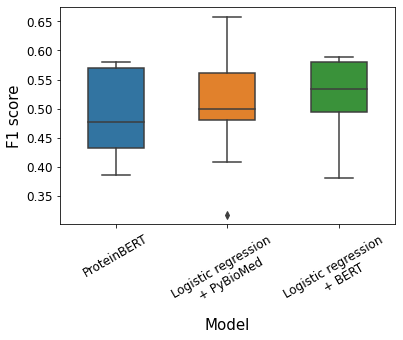

In [49]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(y="F1", x="label", data=to_plot, width=0.5) #, order=order)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, size=12)
plt.yticks(fontsize=12)
ax.set_xlabel("Model", size=15)
ax.set_ylabel("F1 score", size=15)
plt.savefig(path.join(DATA_DIR, "images/box_final_comparison.png"), bbox_inches='tight')
plt.show()